# State of the States map analysis

Elham Ali (Beeck Center for Social Impact and Innovation at Georgetown University)  
September 30, 2025

This analysis aims to explore trends of digital transformation, specifically on policy, chief data officers, digital service teams, impact reports, and design systems across U.S. states and territories.

## Background

When public climate & EJ evidence disappears (removed, restricted, or altered), a decade of downstream knowledge becomes harder to verify, reproduce, teach, or apply—especially for communities and decisions that most need it.  
This analysis looks at how many studies have used these tools, their topics, and their use cases.

## Questions

Here are the key questions explored in this analysis:

-   How many **states/territories** have at least one:

    -   Executive order
    -   AI Legislation
    -   Chief Data Officer (CDO)
    -   Digital Service Team (DST)
    -   Digital Service Impact Report
    -   Design system

-   Which states are the **most active vs. least active** across all categories?

-   Which states introduced **CDOs or DSTs earliest**, and how has that spread across regions?

-   Which states with **active CDOs** also have **design systems** or **DSTs**?

-   Are states with **AI legislation** more likely to have other forms of digital infrastructure (DST, design systems)?

-   What are the **most common policy topics** in executive orders (e.g., broadband, interoperability, AI)?

-   What are the **most common policy topics** in AI legislations orders (e.g., broadband, interoperability, AI)?

-   What is the **trend over time** in the number of executive orders and AI legislations enacted?

-   Do **early adopters** (states with policies from 2010–2015) differ from **late adopters** in 2020–2025?

-   Do states with **higher numbers of executive orders** also pass more legislations or rules?

-   Other ideas: Heatmaps of activity types by state, regional comparisons (Northeast vs. South vs. West), and timelines of adoption by year (EOs, bills, rules).

## Data Sources

The climate tools assessed are:

-   map_data
-   policy_data

The data for this project comes from the Digital Service Network at the Beeck and last refreshed on September 30, 2025.

Original raw datasets are saved in the `data/` folder. This script reduces and cleans those datasets to prepare them for analysis.

------------------------------------------------------------------------

## Cleaning

I start by loading the packages needed for file handling, data wrangling, and visualization.

In [ ]:
## Folder structure helpers
library(here)

here() starts at /Users/elhamali/Documents/Data Projects/state-of-states-map-analysis

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.1.0     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


Attaching package: 'janitor'

The following objects are masked from 'package:stats':

    chisq.test, fisher.test

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Attaching package: 'igraph'

The following objects are masked from 'package:lubridate':

    %--%, union

The following objects are masked from 'package:dplyr':

    as_data_frame, groups, union

The following objects are masked from 'package:purrr':

    compose, simplify

The following object is masked from 'package:tidyr':

    crossing

The following object is masked from 'package:tibble':

    as_data_frame

The following objects are masked from 'package:stats':

    decompose, spectrum

The following object is masked from 'package:base':

    union

### Import raw data

I import all .csv files from the `data/` folder, then save them as .rds files into `output/`. This preserves their structure and speeds up future reads.

In [ ]:
# List all CSV files
csv_files <- list.files(here("data"), pattern = "\\.csv$", full.names = TRUE)

# Read into a list of dataframes
datasets <- map(csv_files, read.csv)
names(datasets) <- tools::file_path_sans_ext(basename(csv_files))

# Save each dataset as .rds in output/
walk2(
  datasets,
  names(datasets),
  ~ saveRDS(.x, here("output", paste0(.y, ".rds")))
)

### Clean both datasets

I apply the same cleaning process to both datasets (map_data and policy_data):

-   Standardize variable names to snake_case
-   Guess variable types (integers, doubles, dates, etc.)
-   Convert responses for ‘executive_orders’, ‘ai_legislations’, ‘digital_service_teams’, ‘digital_service_impact_reports’
    -   yes to 1
    -   no to 0
-   Convert responses for ‘design_systems’
    -   yes to 1
    -   in development to 1
    -   no to 0
    -   unverified to 0
-   Convert responses for ‘chief_data_officers’
    -   yes, state CDO to 1
    -   yes, state CDO equivalent to 1
    -   no to 0
    -   no, vacant to 0
    -   unverified to 0
-   Add a region variable to classify the state’s based on CDC’s four regions [1]
    -   **Northeast**: Includes Connecticut, Maine, Massachusetts, New Hampshire, New Jersey, New York, Pennsylvania, Rhode Island, and Vermont
    -   **Midwest**: Includes Illinois, Indiana, Iowa, Kansas, Michigan, Minnesota, Missouri, Nebraska, North Dakota, Ohio, South Dakota, and Wisconsin
    -   **South**: Includes Alabama, Arkansas, Delaware, District of Columbia, Florida, Georgia, Kentucky, Louisiana, Maryland, Mississippi, North Carolina, Oklahoma, South Carolina, Tennessee, Texas, Virginia, and West Virginia
    -   **West**: Includes Alaska, Arizona, California, Colorado, Hawaii, Idaho, Montana, Nevada, New Mexico, Oregon, Utah, Washington, and Wyoming.
    -   **Territories**: Includes American Samoa, Guam, the Northern Mariana Islands, Puerto Rico, and the U.S. Virgin Islands (not included in CDC’s regional mapping, but I added here to include the territories)

[1] <https://www.cdc.gov/nchs/hus/sources-definitions/geographic-region.htm>

In [ ]:
# -------------------------------------------------------------------
# Libraries
library(here)
library(tidyverse)   # includes dplyr, stringr, readr, etc.
library(janitor)
library(lubridate)
library(forcats)
library(glue)
library(fs)


Attaching package: 'fs'

The following object is masked from 'package:igraph':

    path

I’ll now assign the right variable types for the cleaned datasets.

In [ ]:
library(dplyr)
library(stringr)
library(readr)
library(forcats)

# load inputs created earlier
map_data_clean    <- readr::read_rds(here("output", "map_data_clean.rds"))
policy_data_clean <- readr::read_rds(here("output", "policy_data_clean.rds"))

to_binary <- function(x) {
  if (is.logical(x)) return(as.integer(x))
  if (is.numeric(x)) return(as.integer(x == 1))
  x_chr <- tolower(trimws(as.character(x)))
  x_chr[x_chr == ""] <- NA
  yes_vals <- c("yes","y","true","t","1","present","has","active","in development")
  no_vals  <- c("no","n","false","f","0","absent","none","inactive","unverified","no, vacant")
  as.integer(dplyr::case_when(
    x_chr %in% yes_vals ~ 1L,
    x_chr %in% no_vals  ~ 0L,
    TRUE ~ NA_integer_
  ))
}

to_region_factor <- function(x) {
  # map region labels to codes 1..5
  ref <- c("Northeast","Midwest","South","West","Territories")
  idx <- match(as.character(x), ref)          # NA if label not in ref
  factor(as.character(idx), levels = as.character(seq_along(ref)), ordered = TRUE)
}

# ---------- map_data_clean ----------
map_int_cols <- c(
  "total_number_of_executive_orders",
  "total_number_of_legislation",
  "total_number_of_administrative_rules",
  "publication_year"
)
map_dbl_cols <- c("cdo_year_established")
map_bin_cols <- c(
  "executive_orders","ai_legislations","administrative_rules",
  "digital_service_teams","digital_service_impact_reports",
  "chief_data_officers","design_systems","design_system_open_source_status"
)
map_cat_cols <- c("bill_status")

map_data_clean <- map_data_clean %>%
  mutate(across(everything(), ~ as.character(.))) %>%
  mutate(
    across(any_of(map_int_cols), ~ suppressWarnings(as.integer(readr::parse_number(.)))),
    across(any_of(map_dbl_cols), ~ suppressWarnings(as.double(readr::parse_number(.)))),
    across(any_of(map_bin_cols), to_binary),
    across(any_of(map_cat_cols), ~ forcats::as_factor(trimws(.))),
    region = to_region_factor(region)
  )

# ---------- policy_data_clean ----------
pol_int_cols <- c("executive_order_year_enacted", "legislative_session")
pol_cat_cols <- c("scan_type", "bill_status")

policy_data_clean <- policy_data_clean %>%
  mutate(across(everything(), ~ as.character(.))) %>%
  mutate(
    across(any_of(pol_int_cols), ~ suppressWarnings(as.integer(readr::parse_number(.)))),
    across(any_of(pol_cat_cols), ~ forcats::as_factor(trimws(.))),
    region = to_region_factor(region)
  )

## Analysis

I will look at each question one by one and clean the data as I go. I will organize the data during the analysis before exploring the results. I’ll also export intermediate results into tidy CSV files so they are ready for further visualization and exploration.

### Q1

-   How many **states/territories** have at least one:

    -   Executive order
    -   AI Legislation
    -   Chief Data Officer (CDO)
    -   Digital Service Team (DST)
    -   Digital Service Impact Report
    -   Design system


Attaching package: 'scales'

The following object is masked from 'package:purrr':

    discard

The following object is masked from 'package:readr':

    col_factor

file:////Users/elhamali/Documents/Data Projects/state-of-states-map-analysis/output/q1.html screenshot completed

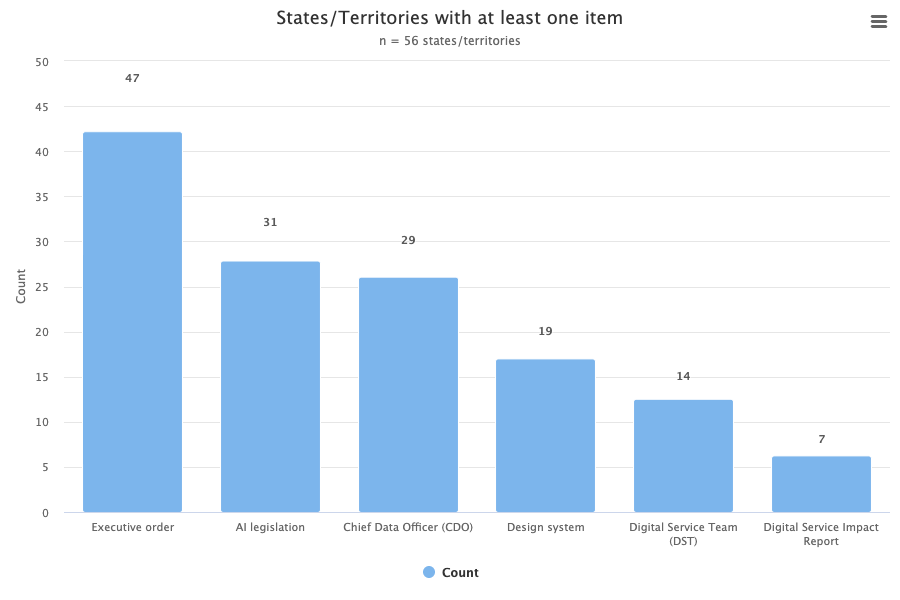

83.9% U.S. states/territories have an executive order.
55.4% U.S. states/territories have AI legislation.
51.8% U.S. states/territories have a chief data office (CDO).
33.9% U.S. states/territories have a design system.
25.0% U.S. states/territories have a digital service team (DST).
12.5% U.S. states/territories have a digital service impact report.

In [ ]:
map_data_clean <- read_rds(here("output", "map_data_clean.rds"))

# Packages
library(tidyverse)
library(highcharter)
library(htmlwidgets)
library(webshot2)
library(glue)
library(scales)

### Q2

-   Which **regions** have the most vs least:

    -   Executive order

    -   AI Legislations

    -   Chief Data Officers (CDO)

    -   Digital Service Teams (DST)

    -   Digital Service Impact Reports

    -   Design systems

I grouped states and territories into CDC regions and flagged whether each had an executive order, AI legislation, a Chief Data Officer (CDO), a Digital Service Team (DST), a Digital Service Impact Report, or a design system. I then summed counts within each region to identify where adoption was highest and lowest.

In [ ]:
library(readr); library(here)
library(dplyr); library(tidyr); library(purrr)
library(glue)

map_data_clean <- read_rds(here("output", "map_data_clean.rds"))

# Indicators
indicators <- c(
  executive_orders                = "Executive order",
  ai_legislations                 = "AI legislation",
  chief_data_officers             = "Chief Data Officer (CDO)",
  digital_service_teams           = "Digital Service Team (DST)",
  digital_service_impact_reports  = "Digital Service Impact Report",
  design_systems                  = "Design system"
)

region_order <- c("Northeast","Midwest","South","West","Territories")

# Prep: one row per state, coerce to logical
map_prepped <- map_data_clean %>%
  distinct(state_territory, .keep_all = TRUE) %>%
  filter(!is.na(region)) %>%
  mutate(region = factor(region, levels = region_order)) %>%
  mutate(across(any_of(names(indicators)),
                ~ dplyr::coalesce(. == 1L | . == TRUE, FALSE)))

# Counts by region & indicator
region_counts <- map_prepped %>%
  select(region, any_of(names(indicators))) %>%
  pivot_longer(-region, names_to = "indicator", values_to = "has_it") %>%
  group_by(region, indicator) %>%
  summarise(count = sum(has_it, na.rm = TRUE), .groups = "drop") %>%
  mutate(label = recode(indicator, !!!indicators)) %>%
  arrange(label, region)

# Find most/least per indicator
most_tbl <- region_counts %>%
  group_by(indicator) %>%
  slice_max(count, with_ties = TRUE) %>%
  ungroup() %>%
  mutate(which = "most")

least_tbl <- region_counts %>%
  group_by(indicator) %>%
  slice_min(count, with_ties = TRUE) %>%
  ungroup() %>%
  mutate(which = "least")

# Build sentences
pretty_regions <- function(x) paste(x, collapse = ", ")
mk_sentence <- function(rows, which, obj) {
  regs <- pretty_regions(rows$region)
  glue("{regs} has the {which} {obj}.")
}

insights_q2 <- tibble(indicator = unique(region_counts$indicator)) %>%
  mutate(
    label = recode(indicator, !!!indicators),
    statement = map_chr(indicator, \(ind) {
      most  <- filter(most_tbl,  indicator == ind)
      least <- filter(least_tbl, indicator == ind)
      paste(
        mk_sentence(most, "most",  recode(ind, !!!indicators)),
        mk_sentence(least, "least", recode(ind, !!!indicators))
      )
    })
  ) %>%
  select(label, statement)

# Save both outputs
write_csv(region_counts, here("output", "region_counts_q2.csv"))
write_csv(insights_q2,  here("output", "insights_q2.csv"))

# Print results in document
# region_counts
insights_q2

# A tibble: 6 × 2
  label                         statement                                       
  <chr>                         <chr>                                           
1 AI legislation                South has the most AI legislation. Territories …
2 Chief Data Officer (CDO)      South, West has the most Chief Data Officer (CD…
3 Design system                 Northeast, South has the most Design system. Te…
4 Digital Service Impact Report Northeast has the most Digital Service Impact R…
5 Digital Service Team (DST)    Northeast has the most Digital Service Team (DS…
6 Executive order               South has the most Executive order. Territories…

### Q3

-   Which states are the **most active vs. least active** across all categories?

To measure overall state activity, I created a six-item score where states received one point for the presence of each digital activity (executive orders, AI legislation, CDO, DST, Digital Service Impact Report, design system). Each state’s score ranged from 0–6 to indicate the breadth of digital transformation. I then ranked states by total score and identified the most and least active states.

In [ ]:
library(readr); library(here)
library(dplyr); library(tidyr); library(purrr); library(glue)

# 1) Load
map_data_clean <- read_rds(here("output", "map_data_clean.rds"))

# 2) Columns (names = dataset column names; values = friendly labels)
act_labels <- c(
  executive_orders               = "Executive orders",
  ai_legislations                = "AI legislations",
  chief_data_officers            = "Chief Data Officers (CDO)",
  digital_service_teams          = "Digital Service Teams (DST)",
  digital_service_impact_reports = "Digital Service Impact Reports",
  design_systems                 = "Design systems"
)

# 3) Presence (0/1) per category, score out of 6 (one row per state)
state_counts_q3 <- map_data_clean %>%
  distinct(state_territory, .keep_all = TRUE) %>%
  transmute(
    state_territory,
    across(
      all_of(names(act_labels)),
      ~ as.integer(dplyr::coalesce(. >= 1L, FALSE))
    )
  ) %>%
  mutate(
    activity_score = rowSums(across(all_of(names(act_labels)))),
    categories_present = pmap_chr(
      across(all_of(names(act_labels))),
      ~ {
        vals <- c(...)
        labs <- act_labels[vals == 1]
        if (length(labs) == 0) "None" else paste(labs, collapse = ", ")
      }
    )
  ) %>%
  arrange(desc(activity_score), state_territory)

# 4) Full ranks (for later viz)
state_ranks_q3 <- state_counts_q3 %>%
  mutate(
    rank_desc = min_rank(desc(activity_score)),  # 1 = most active
    rank_asc  = min_rank(activity_score)        # 1 = least active
  ) %>%
  arrange(rank_desc, state_territory)

# 5) Top/bottom 10 (ties included at the cutoff)
top10 <- state_ranks_q3 %>% filter(rank_desc <= 10)
bot10 <- state_ranks_q3 %>% filter(rank_asc  <= 10)

fmt_list <- function(df) paste0(df$state_territory, " (", df$activity_score, "/6)", collapse = "; ")

insights_q3 <- tibble(
  type = c("Most active (top 10; ties included)", "Least active (bottom 10; ties included)"),
  statement = c(fmt_list(top10), fmt_list(bot10))
)

# 6) Save (match Q2 naming pattern: *_q3.csv) -------------------------------
if (!dir.exists(here("output"))) dir.create(here("output"), recursive = TRUE)
write_csv(state_counts_q3, here("output", "state_counts_q3.csv"))
write_csv(insights_q3,     here("output", "insights_q3.csv"))
write_csv(state_ranks_q3,  here("output", "state_ranks_q3.csv"))

# 7) Print in document (same pattern as Q2)
# state_counts_q3
insights_q3

# A tibble: 2 × 2
  type                                    statement                             
  <chr>                                   <chr>                                 
1 Most active (top 10; ties included)     California (6/6); Colorado (6/6); Mas…
2 Least active (bottom 10; ties included) Alabama (1/6); Alaska (1/6); American…

### Q4

-   Which states introduced **CDOs or DSTs earliest**, and how has that spread across regions?

For CDOs, I filtered to states with an active CDO and recorded the year the office was established. I then identified the earliest and most recent adopters. For DSTs, I imported a separate dataset of team founding years and names, cleaned it, and identified the earliest and latest established teams.

In [ ]:
library(readr); library(here)
library(dplyr); library(glue)

# -------------------------------------------------------------------
# 1) Load map_data_clean
map_data_clean <- read_rds(here("output", "map_data_clean.rds"))

# -------------------------------------------------------------------
# 2) Import and clean dst_data.csv -> dst_data_clean
dst_data_clean <- read_csv(here("data", "dst_data.csv"),
                           show_col_types = FALSE) %>%
  mutate(
    team_year_founded = as.integer(team_year_founded),
    state_territory   = as.character(state_territory),
    team_name         = as.character(team_name)
  )

# Save cleaned DST data
write_rds(dst_data_clean, here("output", "dst_data_clean.rds"))
write_csv(dst_data_clean, here("output", "dst_data_clean.csv"))

# -------------------------------------------------------------------
# 3) CDO analysis
cdo_tbl <- map_data_clean %>%
  distinct(state_territory, .keep_all = TRUE) %>%
  filter(!is.na(cdo_year_established) & chief_data_officers >= 1) %>%
  transmute(state_territory, cdo_year_established)

earliest_cdo <- cdo_tbl %>%
  filter(cdo_year_established == min(cdo_year_established, na.rm = TRUE))
latest_cdo <- cdo_tbl %>%
  filter(cdo_year_established == max(cdo_year_established, na.rm = TRUE))

insights_cdo <- tibble(
  statement = c(
    glue("{earliest_cdo$state_territory} introduced CDOs earliest in {earliest_cdo$cdo_year_established}."),
    glue("{latest_cdo$state_territory} introduced CDOs the latest in {latest_cdo$cdo_year_established}.")
  )
)

# -------------------------------------------------------------------
# 4) DST analysis
dst_tbl <- dst_data_clean %>%
  filter(!is.na(team_year_founded)) %>%
  arrange(team_year_founded)

earliest_dst <- dst_tbl %>%
  filter(team_year_founded == min(team_year_founded, na.rm = TRUE))
latest_dst <- dst_tbl %>%
  filter(team_year_founded == max(team_year_founded, na.rm = TRUE))

insights_dst <- tibble(
  statement = c(
    glue("{earliest_dst$state_territory} introduced its Digital Service Team ({earliest_dst$team_name}) earliest in {earliest_dst$team_year_founded}."),
    glue("{latest_dst$state_territory} introduced its Digital Service Team ({latest_dst$team_name}) the latest in {latest_dst$team_year_founded}.")
  )
)

# -------------------------------------------------------------------
# 5) Save outputs
if (!dir.exists(here("output"))) dir.create(here("output"), recursive = TRUE)

write_csv(cdo_tbl,      here("output", "cdo_years_q4.csv"))
write_csv(insights_cdo, here("output", "insights_cdo_q4.csv"))

write_csv(dst_tbl,      here("output", "dst_years_q4.csv"))
write_csv(insights_dst, here("output", "insights_dst_q4.csv"))

# -------------------------------------------------------------------
# 6) Print in document
cdo_tbl

        state_territory cdo_year_established
1               Arizona                 2024
2              Arkansas                 2017
3            California                 2019
4              Colorado                 2010
5           Connecticut                 2014
6              Delaware                 2018
7  District of Columbia                 2017
8               Florida                 2017
9                Hawaii                 2022
10              Indiana                 2017
11               Kansas                 2024
12                Maine                 2018
13             Maryland                 2021
14        Massachusetts                 2016
15             Michigan                 2023
16             Missouri                 2023
17              Montana                 2021
18               Nevada                 2024
19           New Jersey                 2015
20       North Carolina                 2016
21         North Dakota                 2018
22        

# A tibble: 5 × 1
  statement                                       
  <chr>                                           
1 Colorado introduced CDOs earliest in 2010.      
2 Arizona introduced CDOs the latest in 2024.     
3 Kansas introduced CDOs the latest in 2024.      
4 Nevada introduced CDOs the latest in 2024.      
5 Rhode Island introduced CDOs the latest in 2024.

# A tibble: 15 × 6
   state_territory team_name            team_year_founded team_location_in_org…¹
   <chr>           <chr>                            <int> <chr>                 
 1 Delaware        Delaware Government…              2001 Department of State   
 2 New York        New York State Digi…              2013 Office of General Ser…
 3 Rhode Island    Rhode Island Enterp…              2013 Department of Adminis…
 4 North Carolina  North Carolina Digi…              2015 Department of Informa…
 5 Massachusetts   Massachusetts Digit…              2017 Executive Office of T…
 6 Vermont         Vermont Agency of D…              2017 Governor's Office     
 7 New Jersey      New Jersey Office o…              2018 External nonprofit    
 8 Colorado        Colorado Digital Se…              2019 The Governor's Office…
 9 Connecticut     Connecticut Digital…              2019 Department of Adminis…
10 California      California Office o…              2019 Government Operations…
11 Colora

# A tibble: 4 × 1
  statement                                                                     
  <chr>                                                                         
1 Delaware introduced its Digital Service Team (Delaware Government Information…
2 Arizona introduced its Digital Service Team (Arizona Digital Solutions Office…
3 Maryland introduced its Digital Service Team (Maryland Digital Service (MDDS)…
4 Minnesota introduced its Digital Service Team (Minnesota Digital Services, An…

### Q5

-   Which states with **active CDOs** also have **design systems** or **DSTs**?

I examined whether states with CDOs also adopted other infrastructure (design systems or DSTs). After filtering to states with active CDOs, I tallied how many also had design systems or DSTs. I then compared the likelihood of having a DST between states with and without CDOs using a relative likelihood ratio.

In [ ]:
library(readr); library(here)
library(dplyr); library(glue)

# -------------------------------------------------------------------
# 1) Load cleaned dataset
map_data_clean <- read_rds(here("output", "map_data_clean.rds"))

# -------------------------------------------------------------------
# 2) Prep: keep one row per state/territory, coerce presence to 0/1
q5_tbl <- map_data_clean %>%
  distinct(state_territory, .keep_all = TRUE) %>%
  transmute(
    state_territory,
    cdo    = as.integer(coalesce(chief_data_officers,        0L) >= 1L),
    design = as.integer(coalesce(design_systems,             0L) >= 1L),
    dst    = as.integer(coalesce(digital_service_teams,      0L) >= 1L)
  )

# -------------------------------------------------------------------
# 3) Which states with active CDOs also have design systems or DSTs?
cdo_active <- q5_tbl %>% filter(cdo == 1)

cdo_with_design_or_dst <- cdo_active %>%
  filter(design == 1 | dst == 1)

num_states <- nrow(cdo_with_design_or_dst)
state_names <- paste(cdo_with_design_or_dst$state_territory, collapse = ", ")

# -------------------------------------------------------------------
# 4) Likelihood comparison: probability of DST with CDO vs. without
p_dst_with_cdo <- mean(cdo_active$dst == 1, na.rm = TRUE)
p_dst_without  <- mean(q5_tbl %>% filter(cdo == 0) %>% pull(dst) == 1, na.rm = TRUE)

likelihood_ratio <- ifelse(p_dst_without > 0, p_dst_with_cdo / p_dst_without, NA_real_)

# Round ratio nicely (e.g., 2.2x more likely)
ratio_text <- ifelse(is.na(likelihood_ratio), "undefined",
                     paste0(round(likelihood_ratio, 1), "x more"))

# -------------------------------------------------------------------
# 5) Build insight statements
insights_q5 <- tibble(
  statement = c(
    glue("{num_states} states with active CDOs also have design systems or DSTs. They are {state_names}."),
    glue("States with Chief Data Officers are {ratio_text} likely to have digital service teams.")
  )
)

# -------------------------------------------------------------------
# 6) Save outputs
if (!dir.exists(here("output"))) dir.create(here("output"), recursive = TRUE)
write_csv(q5_tbl,        here("output", "state_counts_q5.csv"))
write_csv(insights_q5,   here("output", "insights_q5.csv"))

# -------------------------------------------------------------------
# 7) Print results
q5_tbl

            state_territory cdo design dst
1                   Alabama   0      0   0
2                    Alaska   0      0   0
3            American Samoa   0      0   0
4                   Arizona   1      0   1
5                  Arkansas   1      0   0
6                California   1      1   1
7                  Colorado   1      1   1
8               Connecticut   1      1   1
9                  Delaware   1      1   1
10     District of Columbia   1      0   0
11                  Florida   1      0   0
12                  Georgia   0      1   0
13                     Guam   0      0   0
14                   Hawaii   1      0   0
15                    Idaho   0      0   0
16                 Illinois   0      1   0
17                  Indiana   1      0   0
18                     Iowa   0      1   0
19                   Kansas   1      0   0
20                 Kentucky   0      0   0
21                Louisiana   0      1   0
22                    Maine   1      0   0
23         

# A tibble: 2 × 1
  statement                                                                     
  <chr>                                                                         
1 13 states with active CDOs also have design systems or DSTs. They are Arizona…
2 States with Chief Data Officers are 3.4x more likely to have digital service …

### Q6

-   Are states with **AI legislation** more likely to have other forms of digital infrastructure (DST, design systems)?

I defined “digital infrastructure” broadly as the presence of any of the following: a CDO, DST, Digital Service Impact Report, or design system. I then compared the probability of having this infrastructure between states with versus without executive orders, AI legislation, or any policy (executive order or AI). Likelihood ratios were calculated to quantify differences, and notable examples were listed.

In [ ]:
library(readr); library(here)
library(dplyr); library(glue)

# Load
map_data_clean <- read_rds(here("output", "map_data_clean.rds"))

# Prep (one row/state; presence 0/1)
q6_tbl <- map_data_clean %>%
  distinct(state_territory, .keep_all = TRUE) %>%
  transmute(
    state_territory,
    eo     = as.integer(coalesce(executive_orders,          0L) >= 1L),
    ai     = as.integer(coalesce(ai_legislations,           0L) >= 1L),
    cdo    = as.integer(coalesce(chief_data_officers,       0L) >= 1L),
    dst    = as.integer(coalesce(digital_service_teams,     0L) >= 1L),
    dsir   = as.integer(coalesce(digital_service_impact_reports, 0L) >= 1L),
    design = as.integer(coalesce(design_systems,            0L) >= 1L)
  ) %>%
  mutate(
    # DEFINITION NOTE:
    # "Digital infrastructure" = present if ANY of the following are present:
    #   CDO OR Digital Service Team (DST) OR Digital Service Impact Report (DSIR) OR Design system
    infra = as.integer(cdo == 1 | dst == 1 | dsir == 1 | design == 1),
    any_policy = as.integer(eo == 1 | ai == 1)
  )

# Helper: ratio + notable examples
calc_ratio <- function(df, policy_col) {
  with_policy    <- df %>% filter(.data[[policy_col]] == 1)
  without_policy <- df %>% filter(.data[[policy_col]] == 0)

  p_with    <- mean(with_policy$infra == 1, na.rm = TRUE)
  p_without <- mean(without_policy$infra == 1, na.rm = TRUE)

  ratio <- ifelse(p_without > 0, p_with / p_without, NA_real_)
  ratio_text <- ifelse(is.na(ratio), "undefined", paste0(round(ratio, 1), "x more"))

  notable <- with_policy %>% filter(infra == 1) %>% pull(state_territory)
  notable_text <- ifelse(length(notable) > 0, paste(notable, collapse = ", "), "None")

  list(ratio_text = ratio_text, notable_text = notable_text)
}

# Ratios + statements
eo_stats  <- calc_ratio(q6_tbl, "eo")
ai_stats  <- calc_ratio(q6_tbl, "ai")
any_stats <- calc_ratio(q6_tbl, "any_policy")

insights_q6 <- tibble(
  statement = c(
    glue("States with executive orders are {eo_stats$ratio_text} likely to have other forms of digital infrastructure (CDO, DST, Digital Service Impact Report, design system). Notable examples are {eo_stats$notable_text}."),
    glue("States with AI legislation are {ai_stats$ratio_text} likely to have other forms of digital infrastructure (CDO, DST, Digital Service Impact Report, design system). Notable examples are {ai_stats$notable_text}."),
    glue("States with any policy (AI legislation and/or executive orders) are {any_stats$ratio_text} likely to have other forms of digital infrastructure (CDO, DST, Digital Service Impact Report, design system). Notable examples are {any_stats$notable_text}.")
  )
)

# Save outputs
if (!dir.exists(here("output"))) dir.create(here("output"), recursive = TRUE)
write_csv(q6_tbl,      here("output", "state_counts_q6.csv"))
write_csv(insights_q6, here("output", "insights_q6.csv"))

# Print results
q6_tbl

            state_territory eo ai cdo dst dsir design infra any_policy
1                   Alabama  1  0   0   0    0      0     0          1
2                    Alaska  1  0   0   0    0      0     0          1
3            American Samoa  1  0   0   0    0      0     0          1
4                   Arizona  0  1   1   1    0      0     1          1
5                  Arkansas  0  1   1   0    0      0     1          1
6                California  1  1   1   1    1      1     1          1
7                  Colorado  1  1   1   1    1      1     1          1
8               Connecticut  1  1   1   1    0      1     1          1
9                  Delaware  1  1   1   1    0      1     1          1
10     District of Columbia  1  0   1   0    0      0     1          1
11                  Florida  1  1   1   0    0      0     1          1
12                  Georgia  1  1   0   0    0      1     1          1
13                     Guam  1  0   0   0    0      0     0          1
14    

# A tibble: 3 × 1
  statement                                                                     
  <chr>                                                                         
1 States with executive orders are 1.1x more likely to have other forms of digi…
2 States with AI legislation are 1.8x more likely to have other forms of digita…
3 States with any policy (AI legislation and/or executive orders) are 1.4x more…

### Q7

-   In which region(s) do **AI legislation cluster** in?

To assess whether AI legislation clusters in particular regions, I calculated both **absolute counts** and **relative proportions**. First, I assigned each state or territory to its CDC region grouping and flagged whether it had AI legislation. I then aggregated by region to count the number of states with AI legislation (absolute clustering) and the percentage of states within the region that had AI legislation (relative clustering). Absolute counts highlight where most AI laws are located overall, while proportions account for differences in region size.

In [ ]:
library(readr); library(here)
library(dplyr); library(glue); library(tidyr)

# 1) Load
map_data_clean <- read_rds(here("output", "map_data_clean.rds"))

# 2) Prep: one row per state/territory with region + AI presence (0/1)
q7_tbl <- map_data_clean %>%
  distinct(state_territory, .keep_all = TRUE) %>%
  transmute(
    state_territory,
    region = as.character(region),
    ai_legislation = as.integer(dplyr::coalesce(ai_legislations, 0L) >= 1L)
  )

# 3) Summarize by region: counts and proportions
region_ai_counts <- q7_tbl %>%
  group_by(region) %>%
  summarise(
    n_states       = n(),
    ai_states      = sum(ai_legislation, na.rm = TRUE),
    percent_with_ai= round(100 * ai_states / n_states, 1),
    .groups = "drop"
  ) %>%
  arrange(desc(ai_states), desc(percent_with_ai))

# 4) Identify clustering by absolute count and by proportion (tie-aware)
max_count <- max(region_ai_counts$ai_states, na.rm = TRUE)
max_prop  <- max(region_ai_counts$percent_with_ai, na.rm = TRUE)

cluster_count_regions <- region_ai_counts %>%
  filter(ai_states == max_count) %>%
  pull(region)

cluster_prop_regions <- region_ai_counts %>%
  filter(percent_with_ai == max_prop) %>%
  pull(region)

fmt_regions <- function(x) paste(x, collapse = ", ")

# 5) Insight statements (both views)
insights_q7 <- tibble(
  statement = c(
    glue("By absolute count, AI legislation tends to cluster in the {fmt_regions(cluster_count_regions)}."),
    glue("By share of states, AI legislation tends to cluster in the {fmt_regions(cluster_prop_regions)}.")
  )
)

# 6) Save
if (!dir.exists(here("output"))) dir.create(here("output"), recursive = TRUE)
write_csv(region_ai_counts, here("output", "region_ai_counts_q7.csv"))
write_csv(insights_q7,      here("output", "insights_q7.csv"))

# 7) Print
region_ai_counts

# A tibble: 5 × 4
  region      n_states ai_states percent_with_ai
  <chr>          <int>     <int>           <dbl>
1 South             17        10            58.8
2 Northeast          9         7            77.8
3 West              13         7            53.8
4 Midwest           12         6            50  
5 Territories        5         1            20  

# A tibble: 2 × 1
  statement                                                            
  <chr>                                                                
1 By absolute count, AI legislation tends to cluster in the South.     
2 By share of states, AI legislation tends to cluster in the Northeast.

### Q8

-   What are the **most common policy topics** in executive orders (e.g., broadband, interoperability, AI)?

### Q9

-   What are the **most common policy topics** in AI legislations orders (e.g., broadband, interoperability, AI)?

### Q10

-   What is the **trend over time** in the number of executive orders and AI legislations enacted?

### Q11

-   Do **early adopters** (states with policies from 2010–2015) differ from **late adopters** in 2020–2025?

### Q12

-   Do certain AI legislation topics **cluster in certain regions**? Do certain executive topics topics cluster in certain regions?

### Other ideas

-   Other ideas: Heatmaps of activity types by state, regional comparisons (Northeast vs. South vs. West), and timelines of adoption by year (EOs, bills, rules).